In [1]:
import numpy as np
import pandas as pd
import os
import sys
import requests
import json
from tabulate import tabulate
from datetime import datetime
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
key = "RF3AMXIFA1Q8TR5D62Y65C1PZBPI46TQKFx"

In [3]:
def callApi(url):
    response = requests.get(url = url)
    data = response.json()
    
    if data["message"] == "OK":
        return data["result"]
    
#     print("Request failed", data)
    return []

In [4]:
def getTxns(addr):
    url = "https://api.etherscan.io/api?module=account&action=txlist&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" \
    % (addr, key)
    result = callApi(url)
    return result

In [5]:
platforms = {
    "Curve": ["0xd533a949740bb3306d119cc777fa900ba034cd52"],
    "Convex Finance":  ["0xf403c135812408bfbe8713b5a23a04b3d48aae31", "0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e", "0xcf50b810e57ac33b91dcf525c6ddd9881b139332", "0x8014595f2ab54cd7c604b00e9fb932176fdc86ae", "0x92cf9e5e4d1dfbf7da0d2bb3e884a68416a65070", "0xd18140b4b819b895a3dba5442f959fa44994af50", "0x5f465e9fcffc217c5849906216581a657cd60605", "0xe98984ad858075813ada4261af47e68a64e28fcc"], 
    "Uniswap": ["0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"],
    "AAVE": ["0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9"],
    "Compound": ["0xc00e94cb662c3520282e6f5717214004a7f26888"],
    "Lido": ["0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84"],
    "Instadapp": ["0x2971adfa57b20e5a416ae5a708a8655a9c74f723", "0x4c8a1BEb8a87765788946D6B19C6C6355194AbEb", "0xFE02a32Cbe0CB9ad9A945576A5bb53A3C123A3A3", "0x97b0B3A8bDeFE8cB9563a3c610019Ad10DB8aD11", "0x8a5419CfC711B2343c17a6ABf4B2bAFaBb06957F", "0xCBA828153d3a85b30B5b912e1f2daCac5816aE9D", "0x619Ad2D02dBeE6ebA3CDbDA3F98430410e892882", "0x33759cF68a3Ab9e8d582d8A4717104848E0fa8B9", "0x28849D2b63fA8D361e5fc15cB8aBB13019884d09"],
    "Yearn Finance": ["0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e"],
    "SushiSwap": ["0x6b3595068778dd592e39a122f4f5a5cf09c90fe2"],
    "Balancer": ["0xba100000625a3754423978a60c9317c58a424e3D"],
    
    "OpenSea": ["0x7Be8076f4EA4A4AD08075C2508e481d6C946D12b", "0x7f268357A8c2552623316e2562D90e642bB538E5"],
    "SuperRare": ["0x6D7c44773C52D396F43c2D511B81aa168E9a7a42"],
    "Looks Rare": ["0xf4d2888d29d722226fafa5d9b24f9164c092421e"],
    "Rarible": ["0xfca59cd816ab1ead66534d82bc21e7515ce441cf"],
    "NiftyGateway": ["0xE052113bd7D7700d623414a0a4585BCaE754E9d5", "0x11ab0243c57C6c1b39F2908AAeBaed7ccf351491"],
    "Foundation": ["0xcDA72070E455bb31C7690a170224Ce43623d0B6f"],

    "Liquity": ["0x66017d22b0f8556afdd19fc67041899eb65a21bb", "0x6DEA81C8171D0bA574754EF6F8b412F2Ed88c54D", "0x4f9Fbb3f1E99B56e0Fe2892e623Ed36A76Fc605d", "0x24179CD81c9e782A4096035f7eC97fB8B783e007", "0x5f98805A4E8be255a32880FDeC7F6728C6568bA0"],
    "Rari Capital": ["0x835482FE0532f169024d5E9410199369aAD5C77E", "0xB465BAF04C087Ce3ed1C266F96CA43f4847D9635"],
    "dYdX": ["0x0fd829C3365A225FB9226e75c97c3A114bD3199e"],
    "Flexa": ["0x4a57E687b9126435a9B19E4A802113e266AdeBde"],
    "Tornado Cash": ["0x77777FeDdddFfC19Ff86DB637967013e6C6A116C"],
    "RenVM": ["0xEB4C2781e4ebA804CE9a9803C67d0893436bB27D", "0x32666B64e9fD0F44916E1378Efb2CFa3B3B96e80", "0x408e41876cCCDC0F92210600ef50372656052a38", "0x2D7b6C95aFeFFa50C068D50f89C5C0014e054f0A"],
    "DeFi Saver": ["0x0528A32fda5beDf89Ba9ad67296db83c9452F28C"],
    "Quickswap": ["0x6c28AeF8977c9B773996d0e8376d2EE379446F2f"],
    "Nexus Mutual": ["0x84EdfFA16bb0b9Ab1163abb0a13Ff0744c11272f", "0xd7c49CEE7E9188cCa6AD8FF264C1DA2e69D4Cf3B"],
    "TrueFi": ["0xA991356d261fbaF194463aF6DF8f0464F8f1c742", "0x23696914Ca9737466D8553a2d619948f548Ee424"],
    "Alchemix": ["0xdBdb4d16EdA451D0503b854CF79D55697F90c8DF", "0xBC6DA0FE9aD5f3b0d58160288917AA56653660E9", "0x0100546F2cD4C9D97f798fFC9755E47865FF7Ee6"],
    "Fei Protocol": ["0x956F47F50A910163D8BF957Cf5846D573E7f87CA"],
    "Notional": ["0x9abd0b8868546105F6F48298eaDC1D9c82f7f683"],
    "C.R.E.A.M. finance": ["0x780F75ad0B02afeb6039672E6a6CEDe7447a8b45", "0xE618C25f580684770f2578FAca31fb7aCB2F5945"],
    "Loopring": ["0x0BABA1Ad5bE3a5C0a66E7ac838a129Bf948f1eA4", "0x4374D3d032B3c96785094ec9f384f07077792768"],
    "Badger DAO": ["0x3472A5A71965499acd81997a54BBA8D852C6E53d"],
    "Synthetix": ["0x823bE81bbF96BEc0e25CA13170F5AaCb5B79ba83"],
    "Index Coop": ["0x72e364F2ABdC788b7E918bc238B21f109Cd634D7", "0x0954906da0Bf32d5479e25f46056d22f08464cab", "0xAa6E8127831c9DE45ae56bB1b0d4D4Da6e5665BD", "0x0B498ff89709d3838a063f1dFA463091F9801c2b"],
    "Saddle": ["0x4f6A43Ad7cba042606dECaCA730d4CE0A57ac62e"],
    "Harvest Finance": ["0xa0246c9032bc3a600820415ae600c6388619a14d"],
    "B.protocol": ["0xbbBBBBB5AA847A2003fbC6b5C16DF0Bd1E725f61"],
    "xDai": ["0x0Ae055097C6d159879521C384F1D2123D1f195e6"],
    "Olympus": ["0x64aa3364F17a4D01c6f1751Fd97C2BD3D7e7f1D5"],
    "Reflexer": ["0x4678f0a6958e4D2Bc4F1BAF7Bc52E8F3564f3fE4"],
    "DeFiDollar": ["0x20c36f062a31865bED8a5B1e512D9a1A20AA333A"],
    "Element Finance": ["0x422494292e7a9Dda8778Bb4EA05C2779a3d60f5D"],
    "Sablier": ["0xCD18eAa163733Da39c232722cBC4E8940b1D8888", "0xbd6a40Bb904aEa5a49c59050B5395f7484A4203d"],
    "Ribbon Finance": ["0x8b5876f5B0Bf64056A89Aa7e97511644758c3E8c", "0x53773E034d9784153471813dacAFF53dBBB78E8c", "0x6123B0049F904d730dB3C36a31167D9d4121fA6B"],
    "Kyber": ["0xdd974D5C2e2928deA5F71b9825b8b646686BD200", "0x1c87257F5e8609940Bc751a07BB085Bb7f8cDBE6"],
    "Vesper": ["0x103cc17C2B1586e5Cd9BaD308690bCd0BBe54D5e", "0xbA4cFE5741b357FA371b506e5db0774aBFeCf8Fc", "0x0C49066C0808Ee8c673553B7cbd99BCC9ABf113d"],
    "Metronome": ["0xa3d58c4e56fedcae3a7c43a725aee9a71f0ece4e"],
    "DeFi Swap": ["0x73854245c99529c4625139041d96fc4e42714c51"],
    "Idle Finance": ["0x3fE7940616e5Bc47b0775a0dccf6237893353bB4"],
    "DODO": ["0x43Dfc4159D86F3A37A5A4B3D4580b888ad7d4DDd"],
    "Origin Dollar": ["0x2A8e1E676Ec238d8A992307B495b45B3fEAa5e86"],
    "Beta Finance": ["0xBe1a001FE942f96Eea22bA08783140B9Dcc09D28"],
    "Strike": ["0x74232704659ef37c08995e386A2E26cc27a8d7B1"],
    "DeversiFi": ["0xDDdddd4301A082e62E84e43F474f044423921918"],
    "Pickle Finance": ["0x429881672B9AE42b8EbA0E26cD9C73711b891Ca5"],
    "O3 Swap": ["0xEe9801669C6138E84bD50dEB500827b776777d28"],
    "Boring Dao": ["0x3c9d6c1C73b31c837832c72E04D3152f051fc1A9"],
    "UMA": ["0x04Fa0d235C4abf4BcF4787aF4CF447DE572eF828"],
    "Bella Flex Saving": ["0xA91ac63D040dEB1b7A5E4d4134aD23eb0ba07e14"],
    "Gnosis": ["0x6810e776880C02933D47DB1b9fc05908e5386b96"],
    "BiFi": ["0x2791BfD60D232150Bff86b39B7146c0eaAA2BA81"],
    "DFX finance": ["0x888888435FDe8e7d4c54cAb67f206e4199454c60"],
    "WePiggy": ["0x27A94869341838D5783368a8503FdA5fbCd7987c"],
    "IDEX": ["0xCc13Fc627EFfd6E35D2D2706Ea3C4D7396c610ea"],
    "Inverse": ["0x41D5D79431A913C4aE7d69a668ecdfE5fF9DFB68"],
    "InsurAce": ["0x544c42fBB96B39B21DF61cf322b5EDC285EE7429"],
    "Cryptex": ["0x321C2fE4446C7c963dc41Dd58879AF648838f98D"],
    "dForce": ["0x431ad2ff6a9C365805eBaD47Ee021148d6f7DBe0"],
    "BarnBridge": ["0x0391D2021f89DC339F60Fff84546EA23E337750f"],
    "Pendle Finance": ["0x808507121B80c02388fAd14726482e061B8da827"],
    "CREAM Swap": ["0x2ba592F78dB6436527729929AAf6c908497cB200"],
    "Mushrooms Finance": ["0xa283aA7CfBB27EF0cfBcb2493dD9F4330E0fd304"],
    "Erasure": ["0x1776e1F26f98b1A5dF9cD347953a26dd3Cb46671"],
    "Integral": ["0xD502F487e1841Fdc805130e13eae80c61186Bc98"],
    "Hegic": ["0xb6A5BAcBB2850Ee4650d08F33F93Df0160fd178C"],
    "DDEX": ["0x20566d84d979841849478E3d17FC81445152B84b"],
    "bZx": ["0x56d811088235F11C8920698a204A5010a788f4b3"],
    "Gamma": ["0x6BeA7CFEF803D1e3d5f7C0103f7ded065644e197"],
    "Premia": ["0x6399C842dD2bE3dE30BF99Bc7D1bBF6Fa3650E70"],
    "PieDAO": ["0xad32A8e6220741182940c5aBF610bDE99E737b2D"],
    "xToken": ["0xdD699Eae49A3504a28AeB9BD76a3f0369fA08471"],
    "Opium Network": ["0x888888888889C00c67689029D7856AAC1065eC11"],
    "Warp Finance": ["0xEd40834A13129509A89be39a9bE9C0E96A0DDd71"],
    "TRANCHE": ["0x0AeE8703D34DD9aE107386d3eFF22AE75Dd616D1"],
    "Crypto Volatility Index": ["0xeEAA40B28A2d1b0B08f6f97bB1DD4B75316c6107"],
    "OnX Finance": ["0xC1330aCBbcE97cb9695B7ee161c0F95B875a8b0F"],
    "Augur": ["0x221657776846890989a759BA2973e427DfF5C9bB"],
    "DerivaDEX": ["0x3A880652F47bFaa771908C07Dd8673A787dAEd3A"],
    "cvault.finance": ["0x62359Ed7505Efc61FF1D56fEF82158CcaffA23D7"],
    "88mph": ["0x8888801aF4d980682e47f1A9036e589479e835C5"],
    "Convergence": ["0xc834Fa996fA3BeC7aAD3693af486ae53D8aA8B50"],
    "MCDEX": ["0x4e352cF164E64ADCBad318C3a1e222E9EBa4Ce42"]
}

In [21]:
def getPlatformsTxns(platforms, dirPath):
    for platform in platforms:
        result = []
        for addr in platforms[platform]:
            result = result + getTxns(addr)

        file = os.path.join(dirPath, "%s.json" % (platform)) 
        with open(file, "w") as f:
            f.write(json.dumps(result))
            
getPlatformsTxns(temp, "data/defi/contractsTxns_12_04")

In [23]:
def getTxnsUsers(dirPath, outFilePath):
    users = set({})

    for path, dirs, files in os.walk(dirPath):
        for file in files:
            filePath = os.path.join(dirPath, file)
            
            with open(filePath, "r") as f:
                data = json.load(f)
                currUsers = [x["from"] for x in data]
                currUsers = set(currUsers)
                users = users.union(currUsers)
                
    with open(outFilePath, "w") as f:
        for user in users:
            f.write(user)
            f.write("\n")
    
    return users

defiUsers = getTxnsUsers("data/defi/contractsTxns_12_04", "data/defi/users/defiUsers_12_04.txt")
nftUsers = getTxnsUsers("data/nft/contractsTxns_12_04", "data/nft/users/nftUsers_12_04.txt")
print(len(defiUsers), len(nftUsers))

253360 28941


In [24]:
def getAllUsers(dirPath):
    allUsers = set({})

    for path, dirs, files in os.walk(dirPath):
        for file in files:
            filePath = os.path.join(path, file)

            with open(filePath, "r") as f:
                users = f.readlines()
                users = set([x[:-1] for x in users])
                allUsers = allUsers.union(users)

    return allUsers

In [25]:
allDefiUsers = getAllUsers("data/defi/users")
print("DeFi Users:", len(allDefiUsers))

allNftUsers = getAllUsers("data/nft/users")
print("NFT Users:", len(allNftUsers))

allUsers = allDefiUsers.union(allNftUsers)
commonUsers = allDefiUsers.intersection(allNftUsers)
print("All Users:", len(allUsers))
print("Common Users:", len(commonUsers))

DeFi Users: 278881
NFT Users: 57171
All Users: 330747
Common Users: 5305


### Splitting Data for Parallelization

In [26]:
def splitUsers(allUsers, divs=6):
    subsets = np.array_split(list(allUsers), divs)
    for i in range(len(subsets)):
        subset = subsets[i]
        strg = "\n".join(subset)
        
        filePath = "data/combinedUsers/%d.txt" % (i)
        with open(filePath, "w") as f:
            f.write(strg)

splitUsers(allUsers)

In [27]:
def getUsersSubset(filePath):
    with open(filePath, "r") as f:
        users = f.readlines()
        users = set([x[:-1] for x in users])
        return users

subUsers = getUsersSubset("data/combinedUsers/0.txt")
print(len(subUsers))

55125


### Extract Features from Users' Transactions

In [9]:
def getBal(addr):
    url = "https://api.etherscan.io/api?module=account&action=balance&address=%s&tag=latest&apikey=%s" % (addr, key)
    bal = float(callApi(url)) / 1e18
    return bal

In [10]:
def getAvgTxnsPerDay(txns, denom = 0):
    timestamps = [int(x["timeStamp"]) for x in txns]
    df = pd.DataFrame(timestamps)
    df[0] = df[0].apply(lambda x: datetime.fromtimestamp(x))
    group = df.groupby([df[0].dt.date]).describe(datetime_is_numeric=True)
    if not denom:
        denom = len(group[(0, 'count')])

    avg_tx_per_day = sum(group[(0, 'count')]) / denom
    return avg_tx_per_day, denom

In [11]:
def getTokenTransfers(addr):
    url = "https://api.etherscan.io/api?module=account&action=tokentx&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" % (addr, key)
    txns = callApi(url)
    
    tokens = {}
    
    for i in txns:
        if i["tokenName"] not in tokens:
            tokens[i["tokenName"]] = {"buys": 0, "sells": 0}
        
        if i['from'] == addr:
            tokens[i["tokenName"]]["sells"] += 1
        else:
            tokens[i["tokenName"]]["buys"] += 1
        
    return tokens

In [12]:
def getNFTTransfers(addr):
    url = "https://api.etherscan.io/api?module=account&action=tokennfttx&address=%s&startblock=0&endblock=99999999&sort=desc&apikey=%s" % (addr, key)
    txns = callApi(url)
    
    nfts = {}
    
    for i in txns:
        if i["tokenName"] not in nfts:
            nfts[i["tokenName"]] = {"buys": 0, "sells": 0}
            
        if i['from'] == addr:
            nfts[i["tokenName"]]["sells"] += 1
        else:
            nfts[i["tokenName"]]["buys"] += 1
            
    return nfts

In [13]:
def clusterTxns(txns, platforms, currAddr):
    finalDict = {}
    platformsTxns = {}
    platAddrMap = {}
    for platform in platforms:
        platformsTxns[platform] = []
        
        for addr in platforms[platform]:
            platAddrMap[addr] = platform
    
    for txn in txns:
        fromAddr = txn["from"]
        toAddr = txn["to"]
        
        if fromAddr != currAddr:
            if fromAddr not in finalDict:
                finalDict[fromAddr] = 0
            finalDict[fromAddr] += 1
            
            if fromAddr in platAddrMap.keys():
                platform = platAddrMap[fromAddr]
                platformsTxns[platform].append(txn)
            
        elif toAddr != currAddr:
            if toAddr not in finalDict:
                finalDict[toAddr] = 0
            finalDict[toAddr] += 1
            
            if toAddr in platAddrMap.keys():
                platform = platAddrMap[toAddr]
                platformsTxns[platform].append(txn)
            
    return finalDict, platformsTxns

In [30]:
def getPlatformCounts(clusters, platforms, dayCount):
    counts = {}
    avgs = {}
    
    for platform in platforms:
        ctr = 0
        for addr in platforms[platform]:
            if addr in list(clusters.keys()):
                ctr += clusters[addr]
        
        if not ctr:
            continue
        counts[platform] = ctr
        avgs[platform] = ctr / dayCount
            
    return counts, avgs

In [16]:
def getUserCounts(clusters, defiUsers, nftUsers):
    defiCommon = set(defiUsers).intersection(set(clusters.keys()))
    nftCommon = set(nftUsers).intersection(set(clusters.keys()))
    counts = {
        "DEFI": {
            "User Count": len(defiCommon),
            "Transaction Count": 0
        },
        "NFT": {
            "User Count": len(nftCommon),
            "Transaction Count": 0
        }
    }
    
    for user in defiCommon:
        counts["DEFI"]["Transaction Count"] += clusters[user]
        
    for user in nftCommon:
        counts["NFT"]["Transaction Count"] += clusters[user]
    
    return counts

In [17]:
def isContract(addr):
    url = "https://api.etherscan.io/api?module=contract&action=getabi&address=%s&apikey=%s" % (addr, key)
    result = callApi(url)
    if result == []:
        return False
    
    return True

In [18]:
def parseOtherAddrs(clusters, platforms, allUsers):
    counts = {}
    platAddrs = []
    for platform in platforms:
        for addr in platforms[platform]:
            platAddrs.append(addr)
            
    for addr in clusters:
        if addr in allUsers or addr in platAddrs:
            continue
            
#         if isContract(addr):
        counts[addr] = clusters[addr]
            
    return counts

In [31]:
def getUserFeats(addr):
    bal = getBal(addr)
    txns = getTxns(addr)
    avgTxnsPerDay, dayCount = getAvgTxnsPerDay(txns)
    clusters, platformsTxns = clusterTxns(txns, platforms, addr)
    platformCounts, platformAvgs = getPlatformCounts(clusters, platforms, dayCount)
    userCounts = getUserCounts(clusters, allDefiUsers, allNftUsers)
    otherPlatformsCount = parseOtherAddrs(clusters, platforms, allUsers)
    tokenTransfers = getTokenTransfers(addr)
    nftTransfers = getNFTTransfers(addr)
    
    feats = {
        "Ether Balance": bal,
        "Overall Transaction Count": len(txns),
        "Average Transactions Per Day": avgTxnsPerDay,
        "Platform Transaction Count": platformCounts,
        "Platform Average Transactions Per Day": platformAvgs,
        "User Counts": userCounts,
        "Other Platforms Count": otherPlatformsCount,
        "Token Transfers": tokenTransfers,
        "NFT Transfers": nftTransfers   
    }
    
    return feats

In [32]:
allFeats = {}

In [33]:
def getAllUsersFeats(users, filePath):
    global allFeats
    
    with open(filePath, "a") as f:
        if allFeats == {}:
            f.write("{")
        
        for user in tqdm(users):
            if user in allFeats.keys():
                continue
                
            feats = getUserFeats(user)
            allFeats[user] = feats
            f.write("\"%s\": " % (user) + json.dumps(feats) + ", ")

    f.write("}")
    return allFeats

getAllUsersFeats(subUsers, "data/combinedUsers/userFeats1.json")

  0%|                                      | 1/18869 [00:09<49:17:38,  9.41s/it]


KeyboardInterrupt: 

In [22]:
print(tabulate([
    ["DEFI Unique Users", len(allUsers)],
    ["NFT Unique Users", len(nftUsers)],
    ["Common Users", len(commonUsers)],
    ["Total Unique Users", len(combinedUsers)]],
    headers=["Label", "Count"]))

Label                 Count
------------------  -------
DEFI Unique Users     50124
NFT Unique Users      28087
Common Users            762
Total Unique Users    77449


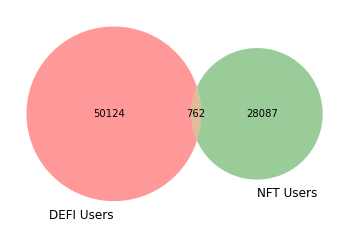

In [24]:
venn2(subsets = (len(allUsers), len(nftUsers), len(commonUsers)), set_labels = ('DEFI Users', 'NFT Users'))